In [7]:
# Importing packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns 
import math
from scipy.stats import skew, norm
from collections import Counter
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler, RobustScaler, StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, KFold
from sklearn.metrics import mean_squared_error, mean_squared_log_error, r2_score
from sklearn import model_selection
from sklearn.pipeline import make_pipeline
from xgboost import XGBRegressor
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import Ridge, RidgeCV, Lasso, LassoCV
from mlxtend.regressor import StackingCVRegressor
from sklearn.metrics import mean_squared_log_error, r2_score

# to ignore warnings
import warnings
warnings.filterwarnings("ignore")


#Show all df colums
pd.set_option('display.max_columns', 82)
pd.set_option('display.max_rows', 82)


In [8]:
# Read csvs
df_train = pd.read_csv(r'C:\Users\brais\OneDrive\Escritorio\Projects\Machine  Learning\HousePricesKaggle\train.csv')
print(df_train.head())
print(df_train.shape)

   Id  MSSubClass MSZoning  LotFrontage  LotArea Street Alley LotShape  \
0   1          60       RL         65.0     8450   Pave   NaN      Reg   
1   2          20       RL         80.0     9600   Pave   NaN      Reg   
2   3          60       RL         68.0    11250   Pave   NaN      IR1   
3   4          70       RL         60.0     9550   Pave   NaN      IR1   
4   5          60       RL         84.0    14260   Pave   NaN      IR1   

  LandContour Utilities LotConfig LandSlope Neighborhood Condition1  \
0         Lvl    AllPub    Inside       Gtl      CollgCr       Norm   
1         Lvl    AllPub       FR2       Gtl      Veenker      Feedr   
2         Lvl    AllPub    Inside       Gtl      CollgCr       Norm   
3         Lvl    AllPub    Corner       Gtl      Crawfor       Norm   
4         Lvl    AllPub       FR2       Gtl      NoRidge       Norm   

  Condition2 BldgType HouseStyle  OverallQual  OverallCond  YearBuilt  \
0       Norm     1Fam     2Story            7          

In [9]:
df_test = pd.read_csv(r'C:\Users\brais\OneDrive\Escritorio\Projects\Machine  Learning\HousePricesKaggle\test.csv')
print(df_test.head())
print(df_test.shape)

     Id  MSSubClass MSZoning  LotFrontage  LotArea Street Alley LotShape  \
0  1461          20       RH         80.0    11622   Pave   NaN      Reg   
1  1462          20       RL         81.0    14267   Pave   NaN      IR1   
2  1463          60       RL         74.0    13830   Pave   NaN      IR1   
3  1464          60       RL         78.0     9978   Pave   NaN      IR1   
4  1465         120       RL         43.0     5005   Pave   NaN      IR1   

  LandContour Utilities LotConfig LandSlope Neighborhood Condition1  \
0         Lvl    AllPub    Inside       Gtl        NAmes      Feedr   
1         Lvl    AllPub    Corner       Gtl        NAmes       Norm   
2         Lvl    AllPub    Inside       Gtl      Gilbert       Norm   
3         Lvl    AllPub    Inside       Gtl      Gilbert       Norm   
4         HLS    AllPub    Inside       Gtl      StoneBr       Norm   

  Condition2 BldgType HouseStyle  OverallQual  OverallCond  YearBuilt  \
0       Norm     1Fam     1Story           

## DATA VALIDATION

In [10]:
# Check differences between columns
train_cols = df_train.columns
test_cols = df_test.columns

diff_cols = [col for col in train_cols if col not in test_cols]
print(f'The diff columns are {diff_cols}')

The diff columns are ['SalePrice']


count      1460.000000
mean     180921.195890
std       79442.502883
min       34900.000000
25%      129975.000000
50%      163000.000000
75%      214000.000000
max      755000.000000
Name: SalePrice, dtype: float64


<AxesSubplot:xlabel='SalePrice'>

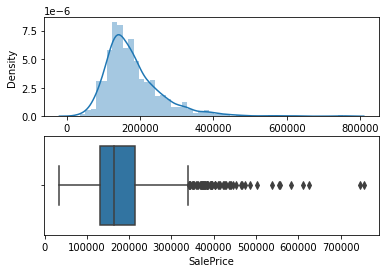

In [11]:
# Now we will analize the target variable
print(df_train['SalePrice'].describe())

fig, (ax1, ax2) = plt.subplots(2, 1)

sns.distplot(df_train['SalePrice'], ax=ax1)

sns.boxplot(df_train['SalePrice'], ax=ax2)

Skewness: 1.882876


<AxesSubplot:xlabel='SalePrice', ylabel='Density'>

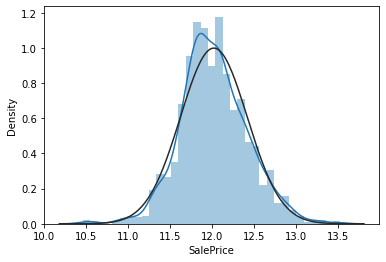

In [12]:
# The target variable has a positive skew, we have to fix it
print('Skewness: %f' % df_train['SalePrice'].skew())

df_train['SalePrice'] = np.log1p(df_train['SalePrice'])

sns.distplot(df_train['SalePrice'], fit=norm)

Now we will concatenate both dataframes in order to perform the data validation process

In [13]:
#Print shapes
print(df_train.shape, df_test.shape)

(1460, 81) (1459, 80)


In [14]:
#Concatenate both data frames
df = pd.concat([df_train, df_test], axis = 0)

#Drop Id column
df.drop('Id', inplace = True, axis = 1)

print(df.columns)
print(df.shape)

Index(['MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'Street', 'Alley',
       'LotShape', 'LandContour', 'Utilities', 'LotConfig', 'LandSlope',
       'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle',
       'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd', 'RoofStyle',
       'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'MasVnrArea',
       'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond',
       'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1', 'BsmtFinType2',
       'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'Heating', 'HeatingQC',
       'CentralAir', 'Electrical', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF',
       'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath',
       'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual', 'TotRmsAbvGrd',
       'Functional', 'Fireplaces', 'FireplaceQu', 'GarageType', 'GarageYrBlt',
       'GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual', 'GarageCond',
       'PavedDrive', 'Wo

In [15]:
print(df.shape)

(2919, 80)


Now we will deal with missing values

In [16]:
#Analyze percentage of missing values per columns
missing = df.isna().sum() / len(df)

print(missing[missing > 0].sort_values(ascending = False))

PoolQC          0.996574
MiscFeature     0.964029
Alley           0.932169
Fence           0.804385
SalePrice       0.499829
FireplaceQu     0.486468
LotFrontage     0.166495
GarageCond      0.054471
GarageYrBlt     0.054471
GarageFinish    0.054471
GarageQual      0.054471
GarageType      0.053786
BsmtExposure    0.028092
BsmtCond        0.028092
BsmtQual        0.027749
BsmtFinType2    0.027407
BsmtFinType1    0.027064
MasVnrType      0.008222
MasVnrArea      0.007879
MSZoning        0.001370
Functional      0.000685
BsmtHalfBath    0.000685
BsmtFullBath    0.000685
Utilities       0.000685
KitchenQual     0.000343
TotalBsmtSF     0.000343
BsmtUnfSF       0.000343
GarageCars      0.000343
GarageArea      0.000343
BsmtFinSF2      0.000343
BsmtFinSF1      0.000343
Exterior2nd     0.000343
Exterior1st     0.000343
SaleType        0.000343
Electrical      0.000343
dtype: float64


We will drop the ones with more than 5.5%, keeping SalePrices as the missing values are due to the concatenation of the DataFrame

In [17]:
#Subset columns to drop
col_drop = missing[(missing > 0.055) & (missing.index != 'SalePrice')].index

#Check columns
print(col_drop)

Index(['LotFrontage', 'Alley', 'FireplaceQu', 'PoolQC', 'Fence',
       'MiscFeature'],
      dtype='object')


In [18]:
#Drop columns
df.drop(col_drop, inplace = True, axis = 1)

#Check results
print(df.columns)

Index(['MSSubClass', 'MSZoning', 'LotArea', 'Street', 'LotShape',
       'LandContour', 'Utilities', 'LotConfig', 'LandSlope', 'Neighborhood',
       'Condition1', 'Condition2', 'BldgType', 'HouseStyle', 'OverallQual',
       'OverallCond', 'YearBuilt', 'YearRemodAdd', 'RoofStyle', 'RoofMatl',
       'Exterior1st', 'Exterior2nd', 'MasVnrType', 'MasVnrArea', 'ExterQual',
       'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond', 'BsmtExposure',
       'BsmtFinType1', 'BsmtFinSF1', 'BsmtFinType2', 'BsmtFinSF2', 'BsmtUnfSF',
       'TotalBsmtSF', 'Heating', 'HeatingQC', 'CentralAir', 'Electrical',
       '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea', 'BsmtFullBath',
       'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr',
       'KitchenQual', 'TotRmsAbvGrd', 'Functional', 'Fireplaces', 'GarageType',
       'GarageYrBlt', 'GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual',
       'GarageCond', 'PavedDrive', 'WoodDeckSF', 'OpenPorchSF',
       'EnclosedPorc

Next we will impute the median for numeric variables, as imputing the median is more robust than imputing the mean because it mitigates the effects of the outliers.

Also we will impute the mode for categorical variables

In [19]:
#Isolate column names with missing values and drop SalePrice
missing = df.isna().sum()
col_names = missing[missing > 0].index.drop('SalePrice')

#Print Result
print(col_names)

#Numeric cols in df
num_col = df.dtypes[df.dtypes != 'object']

#Numeric columns with missing values
num_col_na = [col for col in col_names if col in num_col]

#Print result
print(num_col_na)

Index(['MSZoning', 'Utilities', 'Exterior1st', 'Exterior2nd', 'MasVnrType',
       'MasVnrArea', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1',
       'BsmtFinSF1', 'BsmtFinType2', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF',
       'Electrical', 'BsmtFullBath', 'BsmtHalfBath', 'KitchenQual',
       'Functional', 'GarageType', 'GarageYrBlt', 'GarageFinish', 'GarageCars',
       'GarageArea', 'GarageQual', 'GarageCond', 'SaleType'],
      dtype='object')
['MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'BsmtFullBath', 'BsmtHalfBath', 'GarageYrBlt', 'GarageCars', 'GarageArea']


In [20]:
#Impute median
for col in num_col_na:
    df[col].fillna(df[col].median(), inplace = True)

#Print result
print(df[num_col_na].isna().sum())

MasVnrArea      0
BsmtFinSF1      0
BsmtFinSF2      0
BsmtUnfSF       0
TotalBsmtSF     0
BsmtFullBath    0
BsmtHalfBath    0
GarageYrBlt     0
GarageCars      0
GarageArea      0
dtype: int64


In [21]:
#Isolate categorical columns with missing values
cat_col_na = [col for col in col_names if col not in num_col]

#Print result
print(cat_col_na)

#Impute mode
for col in cat_col_na:
    df[col].fillna(df[col].mode()[0], inplace = True)

#Print results
print(df[cat_col_na].isna().sum())

['MSZoning', 'Utilities', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'Electrical', 'KitchenQual', 'Functional', 'GarageType', 'GarageFinish', 'GarageQual', 'GarageCond', 'SaleType']
MSZoning        0
Utilities       0
Exterior1st     0
Exterior2nd     0
MasVnrType      0
BsmtQual        0
BsmtCond        0
BsmtExposure    0
BsmtFinType1    0
BsmtFinType2    0
Electrical      0
KitchenQual     0
Functional      0
GarageType      0
GarageFinish    0
GarageQual      0
GarageCond      0
SaleType        0
dtype: int64


Next we check for duplicated values and drop if necessary

In [22]:
#Check number of duplicated values
print(df.duplicated().sum())

print(df.shape)

0
(2919, 74)


In [23]:
# Check skewness of numeric data
skew_numeric = df[num_col.index].apply(lambda x: skew(x))

#Print results
print(abs(skew_numeric).sort_values(ascending = False))

#Get names for skewed columns (skew > 0.5)
skewed_cols = skew_numeric[abs(skew_numeric) > 0.5].index

#Apply log transformation
df[skewed_cols] = df[skewed_cols].apply(np.log1p)

MiscVal          21.947195
PoolArea         16.898328
LotArea          12.822431
LowQualFinSF     12.088761
3SsnPorch        11.376065
KitchenAbvGr      4.302254
BsmtFinSF2        4.146143
EnclosedPorch     4.003891
ScreenPorch       3.946694
BsmtHalfBath      3.931594
MasVnrArea        2.613592
OpenPorchSF       2.535114
WoodDeckSF        1.842433
1stFlrSF          1.469604
BsmtFinSF1        1.425378
MSSubClass        1.375457
GrLivArea         1.269358
TotalBsmtSF       1.162616
BsmtUnfSF         0.919703
2ndFlrSF          0.861675
TotRmsAbvGrd      0.758367
Fireplaces        0.733495
HalfBath          0.694566
BsmtFullBath      0.624832
YearBuilt         0.599806
OverallCond       0.570312
YearRemodAdd      0.451020
GarageYrBlt       0.398576
BedroomAbvGr      0.326324
GarageArea        0.241184
GarageCars        0.218593
OverallQual       0.197110
MoSold            0.195884
FullBath          0.167606
YrSold            0.132399
SalePrice              NaN
dtype: float64


## Exploratory analysis

<AxesSubplot:>

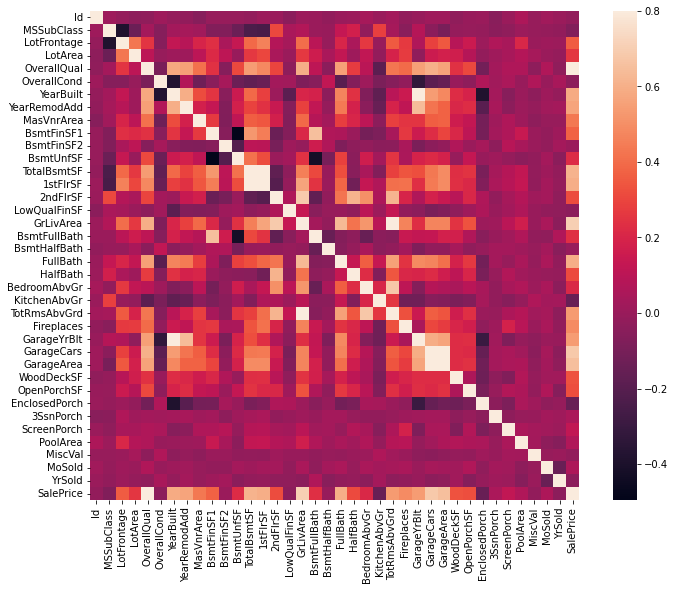

In [24]:
# Analyze correlation between features
corrmat = df_train.corr()
fig, ax = plt.subplots(figsize=(12,9))

#Plot heat map
sns.heatmap(corrmat, vmax=0.8, square=True)

<AxesSubplot:>

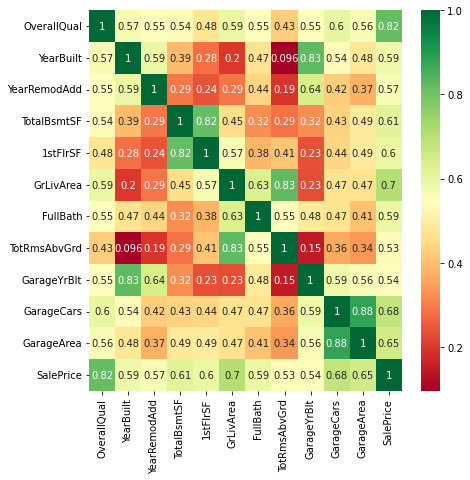

In [25]:
#Select high correlated features
corr = df_train.corr()
high_corr_features = corr.index[abs(corr['SalePrice']) > 0.5]

#Plot heatmap
plt.figure(figsize=(7,7))
sns.heatmap(df_train[high_corr_features].corr(), annot=True, cmap='RdYlGn')

In [26]:
# Highest correlated features with Sale Price
corr['SalePrice'].sort_values(ascending=False)

SalePrice        1.000000
OverallQual      0.817185
GrLivArea        0.700927
GarageCars       0.680625
GarageArea       0.650888
TotalBsmtSF      0.612134
1stFlrSF         0.596981
FullBath         0.594771
YearBuilt        0.586570
YearRemodAdd     0.565608
GarageYrBlt      0.541073
TotRmsAbvGrd     0.534422
Fireplaces       0.489450
MasVnrArea       0.430809
BsmtFinSF1       0.372023
LotFrontage      0.355879
WoodDeckSF       0.334135
OpenPorchSF      0.321053
2ndFlrSF         0.319300
HalfBath         0.313982
LotArea          0.257320
BsmtFullBath     0.236224
BsmtUnfSF        0.221985
BedroomAbvGr     0.209043
ScreenPorch      0.121208
PoolArea         0.069798
MoSold           0.057330
3SsnPorch        0.054900
BsmtFinSF2       0.004832
BsmtHalfBath    -0.005149
Id              -0.017942
MiscVal         -0.020021
OverallCond     -0.036868
YrSold          -0.037263
LowQualFinSF    -0.037963
MSSubClass      -0.073959
KitchenAbvGr    -0.147548
EnclosedPorch   -0.149050
Name: SalePr

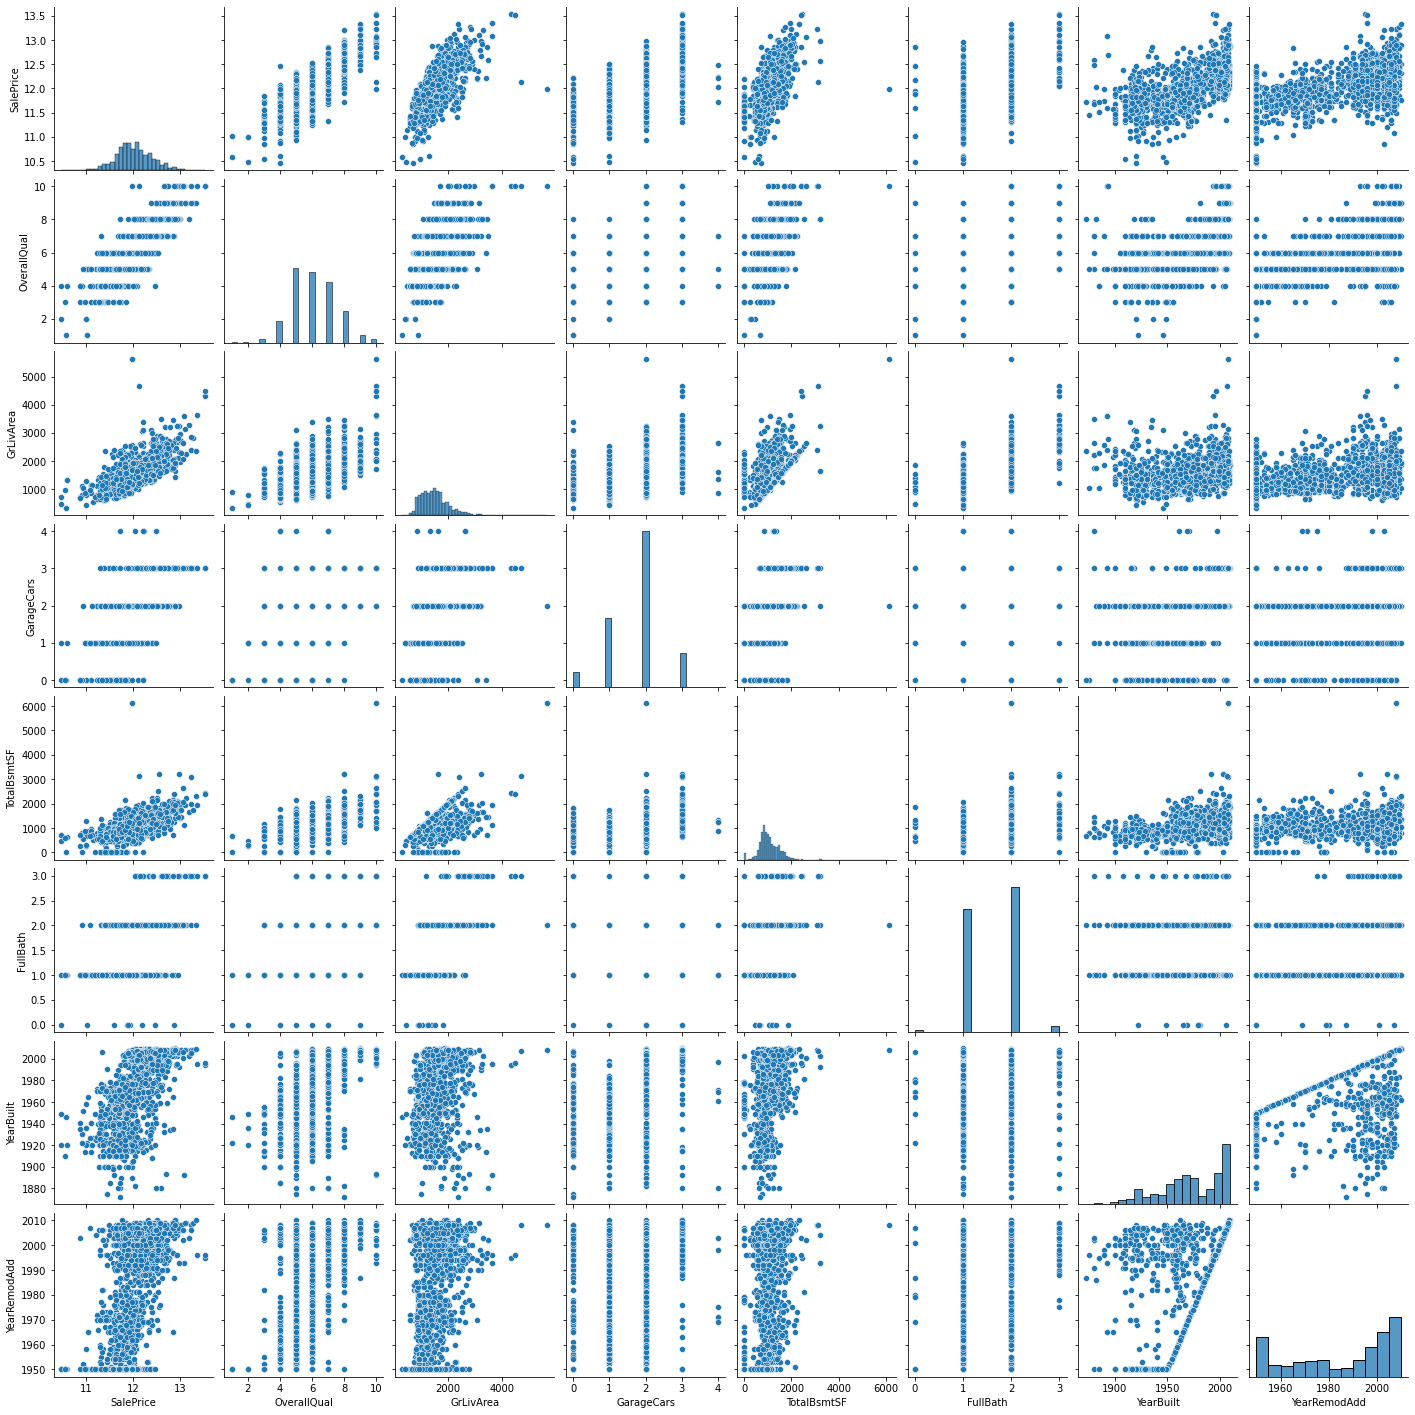

In [27]:
#Top correlated features removing the ones with high correlation between them
corr_cols = ['SalePrice', 'OverallQual', 'GrLivArea', 'GarageCars', 'TotalBsmtSF', 'FullBath', 'YearBuilt', 'YearRemodAdd']

#Plot pairplot
sns.pairplot(df_train[corr_cols])

In [28]:
#Df categorical variables
df_cat = df.select_dtypes('object')

print(df_cat.columns)

Index(['MSZoning', 'Street', 'LotShape', 'LandContour', 'Utilities',
       'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2',
       'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st',
       'Exterior2nd', 'MasVnrType', 'ExterQual', 'ExterCond', 'Foundation',
       'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2',
       'Heating', 'HeatingQC', 'CentralAir', 'Electrical', 'KitchenQual',
       'Functional', 'GarageType', 'GarageFinish', 'GarageQual', 'GarageCond',
       'PavedDrive', 'SaleType', 'SaleCondition'],
      dtype='object')


In [29]:
# Create dummy columns for categorical variables
dummies = pd.get_dummies(df_cat, drop_first=True)

print(dummies)

#Drop categorical columns
df_model = df.drop(df_cat.columns, axis = 1)

#Concatenate dummies
df_model = pd.concat([df_model, dummies], axis = 1)

#Print results
print(df_model.info())

      MSZoning_FV  MSZoning_RH  MSZoning_RL  MSZoning_RM  Street_Pave  \
0               0            0            1            0            1   
1               0            0            1            0            1   
2               0            0            1            0            1   
3               0            0            1            0            1   
4               0            0            1            0            1   
...           ...          ...          ...          ...          ...   
1454            0            0            0            1            1   
1455            0            0            0            1            1   
1456            0            0            1            0            1   
1457            0            0            1            0            1   
1458            0            0            1            0            1   

      LotShape_IR2  LotShape_IR3  LotShape_Reg  LandContour_HLS  \
0                0             0             1          

In [30]:
#Split data
df_train = df_model.iloc[:len(df_train)]
df_test = df_model.iloc[len(df_train):]

#Drop Sale Price column for test
df_test.drop('SalePrice', inplace = True, axis = 1)

print(df_train.shape, df_test.shape)
print(df_train.columns)

(1460, 232) (1459, 231)
Index(['MSSubClass', 'LotArea', 'OverallQual', 'OverallCond', 'YearBuilt',
       'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF',
       ...
       'SaleType_ConLI', 'SaleType_ConLw', 'SaleType_New', 'SaleType_Oth',
       'SaleType_WD', 'SaleCondition_AdjLand', 'SaleCondition_Alloca',
       'SaleCondition_Family', 'SaleCondition_Normal',
       'SaleCondition_Partial'],
      dtype='object', length=232)


In [31]:
#Drop missing values in Sale Price
df_train.dropna(subset = ['SalePrice'], inplace = True)

print(df_train.shape, df_test.shape)

(1460, 232) (1459, 231)


In [32]:
# Create a function to identify outliers:
def outlier_detection(df, n, columns):
    rows = []
    will_drop = []
    for col in columns:
        Q1 = np.nanpercentile(df[col] , 25)
        Q3 = np.nanpercentile(df[col], 75)
        IQR = Q3 -Q1
        outlier_point = IQR * 1.5
        rows.extend(df[(df[col] < Q1 - outlier_point) | (df[col] > Q3 + outlier_point)].index)
    for r, c in Counter(rows).items():
        if c >= n:
            will_drop.append(r)
    return will_drop

#Use fuction
outlier_rows = outlier_detection(df_train, 5, df.select_dtypes(['float','int']).columns)

#Print results
print(df_train.shape)
df_train.drop(outlier_rows, inplace=True, axis=0)
print(df_train.shape)

(1460, 232)
(1449, 232)


In [33]:
#Create model arrays
X = df_train.drop('SalePrice', axis = 1).values
y = df_train['SalePrice'].values
X_test = df_test.values

In [34]:
# # Hyperparameter Tuning for XGBoost
#from sklearn.model_selection import GridSearchCV

#parameters = {
#     "n_estimators": [500, 750, 1000, 1500, 2000], 
#     "learning_rate": [0.01, 0.02, 0.05], 
#     "max_depth": [6, 8], 
#     "subsample": [0.3, 0.5, 0.7]
# }

#grid = GridSearchCV(XGBRegressor(objective='reg:squarederror'), parameters)
#grid.fit(X_train, y_train)

#print(grid.best_params_)

#'learning_rate': 0.01, 'max_depth': 6, 'n_estimators': 2000, 'subsample': 0.3

In [35]:
#Split data into train and validation
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=1007)

In [36]:
# Fit the model with training data
model = XGBRegressor(n_estimators = 2000, learning_rate = 0.01, max_depth = 6, subsample = 0.3)

#Fit model
model.fit(X_train, y_train)

XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
             importance_type=None, interaction_constraints='',
             learning_rate=0.01, max_bin=256, max_cat_to_onehot=4,
             max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
             missing=nan, monotone_constraints='()', n_estimators=2000,
             n_jobs=0, num_parallel_tree=1, predictor='auto', random_state=0,
             reg_alpha=0, reg_lambda=1, ...)

In [37]:
#Print training set results
print("-----")
print("* Training set")
y_pred = model.predict(X_train)
print(f"R2: {r2_score(y_train, y_pred):.2%}")
print(f"RMSE: {mean_squared_log_error(y_train, y_pred, squared=False):.5f}")

#Print validations set results
print("-----")
print("* Validation set")
y_pred = model.predict(X_val)
print(f"R2: {r2_score(y_val, y_pred):.2%}")
print(f"RMSE: {mean_squared_log_error(y_val, y_pred, squared=False):.5f}")

-----
* Training set
R2: 99.18%
RMSE: 0.00276
-----
* Validation set
R2: 91.11%
RMSE: 0.00916


In [39]:
#Predictions
predictions = model.predict(X_test)

#Get test for ids
test = pd.read_csv(r'C:\Users\brais\OneDrive\Escritorio\Projects\Machine  Learning\HousePricesKaggle\test.csv')

#Create final df
submission = pd.DataFrame({'Id': test['Id'], 'SalePrice': predictions})

#Undo logp1 transformation
submission['SalePrice'] = submission['SalePrice'].apply(np.expm1)
submission['SalePrice'] = submission['SalePrice'].apply(np.floor)

#Print results
print(submission.head())
print(submission.shape)

#Generate csv
submission.to_csv("submission_regression1.csv", index=False)

     Id  SalePrice
0  1461   119646.0
1  1462   159025.0
2  1463   192770.0
3  1464   193375.0
4  1465   191594.0
(1459, 2)
